<a href="https://colab.research.google.com/github/IvanSalinas2000/Preprocesamiento-y-clasificacion-de-datos/blob/main/Tarea%206/Tarea6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hub
!pip install av
!pip install "deeplake<4"
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 639.9/639.9 kB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of s3transfer to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 65.5 MB/s eta 0:00:00
   ━━━━━

In [2]:
import hub
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, f1_score

/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.1.12) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [17]:
# Cargar el dataset
ds = hub.load("hub://activeloop/spoken_mnist")

\

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



/

hub://activeloop/spoken_mnist loaded successfully.



In [ ]:
ds0= ds[0]
# Obtener la cantidad de filas en el dataset
lends= len(ds)
print('dataset:',ds0,'#deFilas:',lends)

dataset: Dataset(path='hub://activeloop/spoken_mnist', read_only=True, index=Index([0]), tensors=['spectrograms', 'labels', 'audio', 'speakers']) #deFilas: 3000


In [ ]:
# Obtener el tensor de los hablantes (speakers)
speakers = ds['speakers'].numpy()
# Convertir cada hablante a una cadena y crear un conjunto para obtener los hablantes únicos
unique_speakers = set([str(speaker) for speaker in speakers])
print(unique_speakers)
# Obtener el tensor de labels
labels = ds['labels'].numpy()

# Convertir cada etiqueta a una cadena y crear un conjunto para obtener las etiquetas únicas
unique_labels = set([str(label) for label in labels])

# Mostrar las etiquetas únicas
print(unique_labels)


{"['theo']", "['lucas']", "['george']", "['nicolas']", "['jackson']", "['yweweler']"}
{'[1]', '[7]', '[8]', '[9]', '[4]', '[5]', '[3]', '[6]', '[2]', '[0]'}


In [18]:
# Obtener los tensores relevantes
speakers = ds['speakers'].numpy()  # Hablantes
spectrograms = ds['spectrograms'].numpy()  # Espectrogramas precalculados
labels = ds['labels'].numpy()      # Etiquetas (dígitos del 0 al 9)
audio = ds['audio'].numpy(aslist=True)  # Audios crudos

# Convertir los hablantes a cadenas
speakers = np.array([str(speaker) for speaker in speakers])

# Filtrar para incluir solo george, lucas y nicolas
selected_speakers = {"['george']", "['lucas']", "['nicolas']"}
mask = np.isin(speakers, list(selected_speakers))

# Aplicar el filtro
filtered_speakers = speakers[mask]
filtered_spectrograms = spectrograms[mask]  # Filtrar espectrogramas
filtered_labels = labels[mask]
filtered_audio = [audio[i] for i in range(len(audio)) if mask[i]]  # Filtrar audios

# Seleccionar solo el 50% de los datos (después de filtrar)
subset_size = int(len(filtered_spectrograms) * 0.5)
filtered_spectrograms = filtered_spectrograms[:subset_size]
filtered_speakers = filtered_speakers[:subset_size]
filtered_labels = filtered_labels[:subset_size]
filtered_audio = filtered_audio[:subset_size]  # Filtrar audios correctamente

# Reducir los 4 canales a 1 (promediar los canales)
filtered_spectrograms = np.mean(filtered_spectrograms, axis=-1, keepdims=True)

# Convertir los nombres de los hablantes a etiquetas numéricas
label_encoder = LabelEncoder()
speaker_labels = label_encoder.fit_transform(filtered_speakers)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(filtered_spectrograms, speaker_labels, test_size=0.3, random_state=42)

# Balancear las clases
def balance_classes(X, y):
    unique_classes, counts = np.unique(y, return_counts=True)
    min_samples = min(counts)  # Número mínimo de muestras en una clase
    balanced_X = []
    balanced_y = []
    for cls in unique_classes:
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        X_resampled = resample(X_cls, n_samples=min_samples, random_state=42)
        y_resampled = np.full(min_samples, cls)
        balanced_X.append(X_resampled)
        balanced_y.append(y_resampled)
    balanced_X = np.concatenate(balanced_X)
    balanced_y = np.concatenate(balanced_y)
    return balanced_X, balanced_y

# Balancear X_train y y_train juntos
X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)

# Verificar las formas
print(f"Forma de X_train_balanced: {X_train_balanced.shape}")
print(f"Forma de y_train_balanced: {y_train_balanced.shape}")

# Construir un modelo más simple
model = models.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 clases: george, lucas, nicolas
])

# Compilar el modelo con un learning rate más bajo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train_balanced, y_train_balanced, epochs=10, validation_data=(X_test, y_test))  # Número de épocas reducido a 10

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Precisión en el conjunto de prueba: {test_acc}")

# Predecir las etiquetas para el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Generar el informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calcular el F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")


Forma de X_train_balanced: (513, 64, 64, 1)
Forma de y_train_balanced: (513,)
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.3928 - loss: 13.0218 - val_accuracy: 0.3511 - val_loss: 10.2948
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.3419 - loss: 6.1697 - val_accuracy: 0.4533 - val_loss: 2.1340
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.6004 - loss: 1.0380 - val_accuracy: 0.7956 - val_loss: 0.5246
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.7917 - loss: 0.5088 - val_accuracy: 0.8356 - val_loss: 0.3829
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.9192 - loss: 0.2067 - val_accuracy: 0.9911 - val_loss: 0.0893
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.9872 - loss: 0.0864 - val_accuracy: 0.9956 - val_loss: 0.0644
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9924 - loss: 0.0500 - val_accuracy: 1.0000 - val_loss: 0.0449
Epoch 8/10
17/17 ━━━━━━━

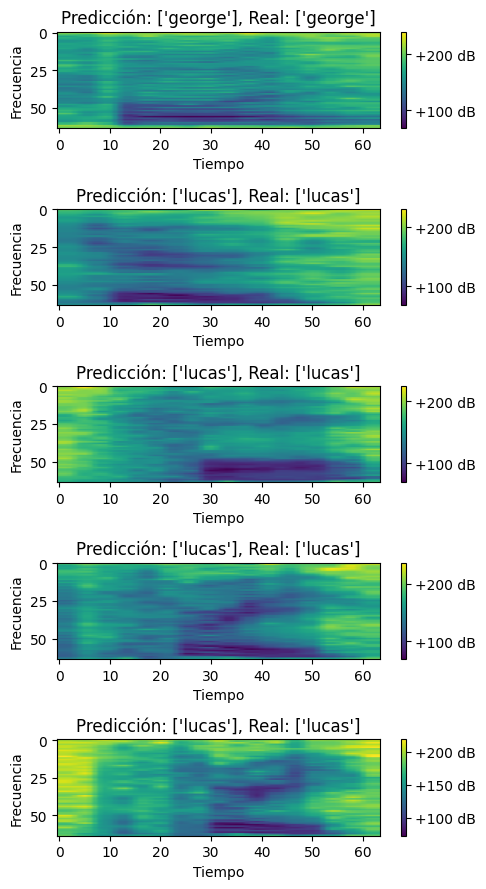

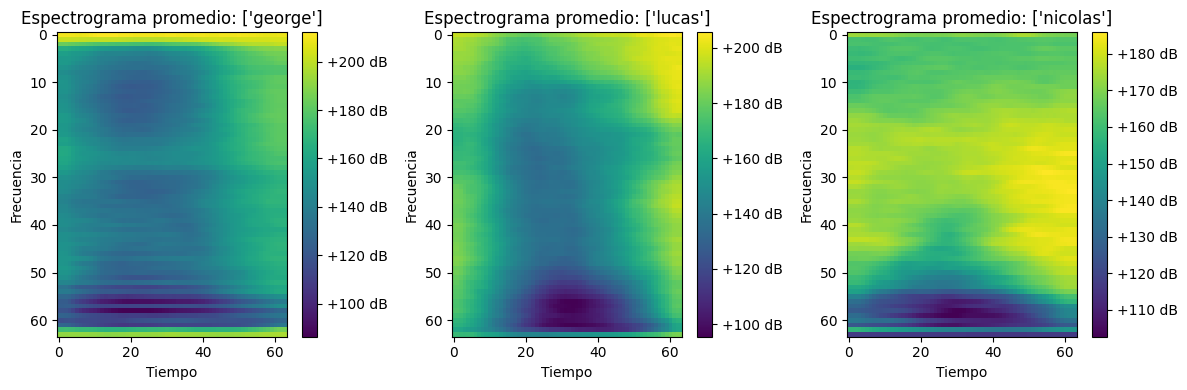

In [14]:
# Graficar algunas predicciones
num_samples = 5
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

plt.figure(figsize=(5, 9))
for i, idx in enumerate(sample_indices):
    plt.subplot(num_samples, 1, i + 1)
    plt.imshow(X_test[idx].squeeze(), cmap='viridis', aspect='auto')
    plt.title(f"Predicción: {label_encoder.classes_[y_pred[idx]]}, Real: {label_encoder.classes_[y_test[idx]]}")
    plt.colorbar(format="%+2.0f dB")
    plt.xlabel("Tiempo")
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Graficar espectrogramas promedio por hablante
average_spectrograms = []
for cls in np.unique(speaker_labels):
    cls_spectrograms = X_train_balanced[y_train_balanced == cls]
    average_spectrogram = np.mean(cls_spectrograms, axis=0)
    average_spectrograms.append(average_spectrogram)

plt.figure(figsize=(12, 4))
for i, avg_spectrogram in enumerate(average_spectrograms):
    plt.subplot(1, 3, i + 1)
    plt.imshow(avg_spectrogram.squeeze(), cmap='viridis', aspect='auto')
    plt.title(f"Espectrograma promedio: {label_encoder.classes_[i]}")
    plt.colorbar(format="%+2.0f dB")
    plt.xlabel("Tiempo")
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



\

hub://activeloop/spoken_mnist loaded successfully.



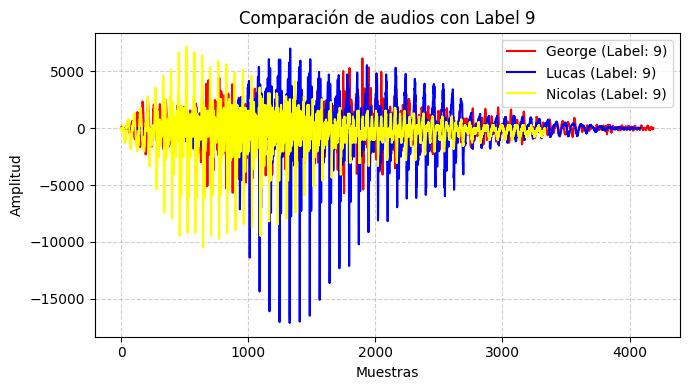

In [5]:
import hub
import numpy as np
import matplotlib.pyplot as plt

# Cargar el dataset
ds = hub.load("hub://activeloop/spoken_mnist")

# Obtener los tensores relevantes
speakers = ds['speakers'].numpy()  # Hablantes
audio = ds['audio'].numpy(aslist=True)  # Audios crudos
labels = ds['labels'].numpy()  # Etiquetas (dígitos del 0 al 9)

# Convertir los hablantes a cadenas
speakers = np.array([str(speaker) for speaker in speakers])

# Filtrar para incluir solo george, lucas y nicolas
selected_speakers = {"['george']", "['lucas']", "['nicolas']"}
mask = np.isin(speakers, list(selected_speakers))

# Aplicar el filtro
filtered_speakers = speakers[mask]
filtered_audio = [audio[i] for i in range(len(audio)) if mask[i]]  # Filtrar audios
filtered_labels = labels[mask]  # Filtrar etiquetas

# Función para encontrar el primer audio con un label específico
def find_audio_by_label(audio_list, labels_list, target_label):
    for i, label in enumerate(labels_list):
        if label == target_label:
            return audio_list[i]
    return None

# Encontrar el audio con label 9 para cada hablante
george_audio_9 = find_audio_by_label(
    [filtered_audio[i] for i in range(len(filtered_audio)) if filtered_speakers[i] == "['george']"],
    [filtered_labels[i] for i in range(len(filtered_labels)) if filtered_speakers[i] == "['george']"],
    target_label=9
)

lucas_audio_9 = find_audio_by_label(
    [filtered_audio[i] for i in range(len(filtered_audio)) if filtered_speakers[i] == "['lucas']"],
    [filtered_labels[i] for i in range(len(filtered_labels)) if filtered_speakers[i] == "['lucas']"],
    target_label=9
)

nicolas_audio_9 = find_audio_by_label(
    [filtered_audio[i] for i in range(len(filtered_audio)) if filtered_speakers[i] == "['nicolas']"],
    [filtered_labels[i] for i in range(len(filtered_labels)) if filtered_speakers[i] == "['nicolas']"],
    target_label=9
)

# Verificar que se encontraron los audios
if george_audio_9 is None or lucas_audio_9 is None or nicolas_audio_9 is None:
    print("No se encontró un audio con label 9 para todos los hablantes.")
else:
    # Graficar los audios en una sola gráfica
    plt.figure(figsize=(7, 4))

    # George en rojo
    plt.plot(george_audio_9, color='red', label="George (Label: 9)")

    # Lucas en azul
    plt.plot(lucas_audio_9, color='blue', label="Lucas (Label: 9)")

    # Nicolas en amarillo
    plt.plot(nicolas_audio_9, color='yellow', label="Nicolas (Label: 9)")

    # Añadir detalles a la gráfica
    plt.title("Comparación de audios con Label 9")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



-

hub://activeloop/spoken_mnist loaded successfully.



Amplitudes George: -133.50658253654433 -62.4672111360283
Amplitudes Lucas: -348.5494360509635 -294.7311690777546
Amplitudes Nicolas: -151.650865896587 -74.60681943937057


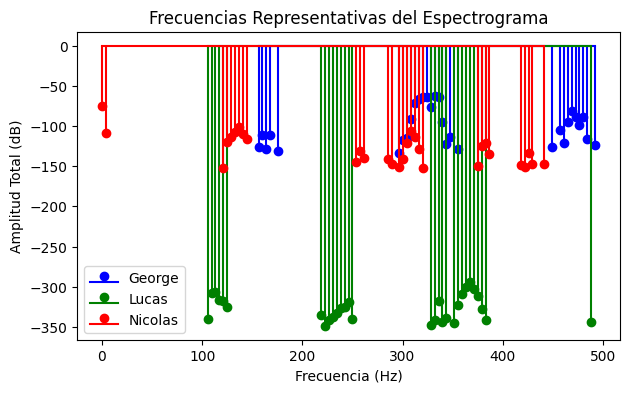

In [6]:
import hub
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Cargar el dataset
ds = hub.load("hub://activeloop/spoken_mnist")

# Obtener los tensores relevantes
speakers = ds['speakers'].numpy()  # Hablantes
audio = ds['audio'].numpy(aslist=True)  # Audios crudos
labels = ds['labels'].numpy()  # Etiquetas (dígitos del 0 al 9)

# Convertir los hablantes a cadenas
speakers = np.array([str(speaker) for speaker in speakers])

# Filtrar para incluir solo george, lucas y nicolas
selected_speakers = {"['george']", "['lucas']", "['nicolas']"}
mask = np.isin(speakers, list(selected_speakers))

# Aplicar el filtro
filtered_speakers = speakers[mask]
filtered_audio = [audio[i] for i in range(len(audio)) if mask[i]]  # Filtrar audios
filtered_labels = labels[mask]  # Filtrar etiquetas

# Función para calcular las frecuencias representativas
def get_top_frequencies(audio_data, sr=8000, top_n=30):
    # Convertir el audio a 1D si es necesario
    audio_data = np.squeeze(audio_data)

    # Calcular la transformada de Fourier de tiempo corto (STFT)
    S = librosa.stft(audio_data)

    # Convertir las amplitudes a decibelios
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Sumar las amplitudes a lo largo del tiempo para cada frecuencia
    sum_amplitudes = np.sum(S_db, axis=1)

    # Obtener las frecuencias correspondientes
    frequencies = librosa.fft_frequencies(sr=sr)

    # Seleccionar las frecuencias más representativas
    top_indices = np.argsort(sum_amplitudes)[-top_n:][::-1]
    top_frequencies = frequencies[top_indices]
    top_amplitudes = sum_amplitudes[top_indices]

    return top_frequencies, top_amplitudes

# Filtrar audios y etiquetas por hablante
george_audio = [filtered_audio[i] for i in range(len(filtered_audio)) if filtered_speakers[i] == "['george']"]
lucas_audio = [filtered_audio[i] for i in range(len(filtered_audio)) if filtered_speakers[i] == "['lucas']"]
nicolas_audio = [filtered_audio[i] for i in range(len(filtered_audio)) if filtered_speakers[i] == "['nicolas']"]

# Calcular las frecuencias representativas para cada hablante
george_frequencies, george_amplitudes = get_top_frequencies(george_audio[0])
lucas_frequencies, lucas_amplitudes = get_top_frequencies(lucas_audio[0])
nicolas_frequencies, nicolas_amplitudes = get_top_frequencies(nicolas_audio[0])

# Verificar las amplitudes
print("Amplitudes George:", np.min(george_amplitudes), np.max(george_amplitudes))
print("Amplitudes Lucas:", np.min(lucas_amplitudes), np.max(lucas_amplitudes))
print("Amplitudes Nicolas:", np.min(nicolas_amplitudes), np.max(nicolas_amplitudes))

# Graficar las frecuencias representativas de los tres hablantes
plt.figure(figsize=(7, 4))
plt.stem(george_frequencies, george_amplitudes, linefmt='b-', markerfmt='bo', basefmt='b-', label='George')
plt.stem(lucas_frequencies, lucas_amplitudes, linefmt='g-', markerfmt='go', basefmt='g-', label='Lucas')
plt.stem(nicolas_frequencies, nicolas_amplitudes, linefmt='r-', markerfmt='ro', basefmt='r-', label='Nicolas')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud Total (dB)')
plt.title('Frecuencias Representativas del Espectrograma')
plt.legend()
plt.show()